# <span style='color:Gainsboro; font-size:45px'>Projeto de Estudo em Ciência de Dados</span>


## <span style='color:SteelBlue; font-size:25px'>Projeto - Análise de custo de vida global</span>

<span style='color:Gray; font-size:15px'>Desenvolvido por: Alan Figueroa</span>


#### Dados
Esta é uma comparação do custo de vida em várias cidades, conforme coletado pelo site popular numbeo . Todos os dados pertencem a eles e foram compartilhados com permissão.A moeda é o Euro.
https://www.kaggle.com/datasets/stephenofarrell/cost-of-living

In [1]:
# Imports
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as pyo
import seaborn as sns
import matplotlib.pyplot as plt

import folium
from folium import Circle
import geopy
import watermark
%reload_ext watermark 
%watermark --iversions
# pode haver outras importações do decorrer do notebook

seaborn   : 0.11.2
folium    : 0.12.1.post1
watermark : 2.3.1
matplotlib: 3.5.1
geopy     : 2.2.0
plotly    : 5.6.0
pandas    : 1.4.2
numpy     : 1.21.5



In [2]:
# Configurações de exibição do pandas
pd.options.display.max_columns = 180
pd.options.display.max_rows = 180

In [3]:
# Carregando os dados
df = pd.read_csv('data/cost-of-living.csv')
df.shape

(55, 161)

In [5]:
# Transpor os dados
df = df.T
df.rename(columns=df.iloc[0], inplace=True)
df.drop(df.index[0], inplace=True)
df = df.reset_index()
df.rename(columns={'index':'Location'}, inplace=True)
df.head()

,Location,"Meal, Inexpensive Restaurant","Meal for 2 People, Mid-range Restaurant, Three-course",McMeal at McDonalds (or Equivalent Combo Meal),Domestic Beer (0.5 liter draught),Imported Beer (0.33 liter bottle),Coke/Pepsi (0.33 liter bottle),Water (0.33 liter bottle),"Milk (regular), (1 liter)",Loaf of Fresh White Bread (500g),Eggs (regular) (12),Local Cheese (1kg),Water (1.5 liter bottle),Bottle of Wine (Mid-Range),Domestic Beer (0.5 liter bottle),Imported Beer (0.33 liter bottle),Cigarettes 20 Pack (Marlboro),One-way Ticket (Local Transport),"Chicken Breasts (Boneless, Skinless), (1kg)",Monthly Pass (Regular Price),Gasoline (1 liter),Volkswagen Golf,Apartment (1 bedroom) in City Centre,Apartment (1 bedroom) Outside of Centre,Apartment (3 bedrooms) in City Centre,Apartment (3 bedrooms) Outside of Centre,"Basic (Electricity, Heating, Cooling, Water, Garbage) for 85m2 Apartment",1 min. of Prepaid Mobile Tariff Local (No Discounts or Plans),"Internet (60 Mbps or More, Unlimited Data, Cable/ADSL)","Fitness Club, Monthly Fee for 1 Adult",Tennis Court Rent (1 Hour on Weekend),"Cinema, International Release, 1 Seat",1 Pair of Jeans (Levis 501 Or Similar),"1 Summer Dress in a Chain Store (Zara, H&M, ...)",1 Pair of Nike Running Shoes (Mid-Range),1 Pair of Men Leather Business Shoes,Price per Square Meter to Buy Apartment in City Centre,Price per Square Meter to Buy Apartment Outside of Centre,Average Monthly Net Salary (After Tax),"Mortgage Interest Rate in Percentages (%), Yearly, for 20 Years Fixed-Rate",Taxi Start (Normal Tariff),Taxi 1km (Normal Tariff),Taxi 1hour Waiting (Normal Tariff),Apples (1kg),Oranges (1kg),Potato (1kg),Lettuce (1 head),Cappuccino (regular),"Rice (white), (1kg)",Tomato (1kg),Banana (1kg),Onion (1kg),Beef Round (1kg) (or Equivalent Back Leg Red Meat),Toyota Corolla 1.6l 97kW Comfort (Or Equivalent New Car),"Preschool (or Kindergarten), Full Day, Private, Monthly for 1 Child","International Primary School, Yearly for 1 Child"
0,"Saint Petersburg, Russia",7.34,29.35,4.4,2.2,2.2,0.76,0.53,0.98,0.71,1.18,7.6,0.63,5.87,0.88,1.89,2.2,0.59,3.96,42.56,0.67,19289.39,524.45,344.27,1012.53,615.19,102.17,0.03,6.96,26.27,18.33,5.14,71.86,38.25,74.88,100.72,2476.05,1507.7,645.94,10.29,1.47,0.26,4.4,1.29,1.25,0.56,0.86,1.96,0.92,1.91,0.89,0.48,7.18,19305.29,411.83,5388.86
1,"Istanbul, Turkey",4.58,15.28,3.82,3.06,3.06,0.64,0.24,0.71,0.36,1.62,5.32,0.33,7.64,1.79,2.48,2.75,0.41,3.5,31.32,1.05,24443.15,291.55,177.72,545.5,314.98,59.33,0.11,14.2,25.1,15.66,3.82,36.15,25.91,61.31,50.58,1315.18,657.05,436.0,19.08,0.76,0.47,3.59,0.85,0.86,0.59,0.61,1.84,1.3,0.8,1.91,0.62,9.73,20874.72,282.94,6905.43
2,"Izmir, Turkey",3.06,12.22,3.06,2.29,2.75,0.61,0.22,0.65,0.38,1.51,4.97,0.29,6.11,1.63,2.09,2.29,0.46,3.05,22.92,1.04,24443.15,212.22,128.36,353.76,225.34,51.07,0.09,12.89,20.64,11.67,3.06,33.2,22.48,52.74,42.2,856.54,508.14,392.07,22.23,0.61,0.57,3.51,0.77,0.73,0.52,0.57,1.56,1.31,0.7,1.78,0.58,8.61,20898.83,212.18,4948.41
3,"Helsinki, Finland",12.0,65.0,8.0,6.5,6.75,2.66,1.89,0.96,2.27,2.02,6.87,1.54,12.0,2.23,2.95,7.7,2.8,9.42,59.7,1.54,22000.0,986.93,758.13,1819.32,1271.16,82.66,0.07,22.31,34.54,24.72,14.0,83.41,31.41,82.49,120.97,7444.54,4099.36,2382.56,1.38,6.0,1.0,47.04,2.1,1.75,0.91,2.3,3.87,2.13,2.91,1.61,1.25,12.34,24402.77,351.6,1641.0
4,"Chisinau, Moldova",4.67,20.74,4.15,1.04,1.43,0.64,0.44,0.68,0.33,1.11,5.79,0.59,3.61,0.77,1.38,1.56,0.1,3.55,9.33,0.98,16335.12,244.49,177.96,428.67,330.84,113.46,0.07,8.58,26.64,12.1,5.19,56.54,35.37,86.25,94.38,904.82,589.13,286.95,9.42,1.3,0.18,3.11,0.7,1.22,0.56,0.84,1.25,0.93,1.56,1.37,0.59,5.37,17238.13,210.52,2679.3


In [6]:
# As colunas foram transformadas para objeto. Transformando novamente como numéricas:
df.iloc[:,1:] = df.iloc[:,1:].astype(float)

In [7]:
# Extraindo latitude e longitude
# Criando localizador
locator = geopy.Nominatim(user_agent='myGeocoder')
location = locator.geocode('Saint Petersburg, Russia')
print(f'Latitude:{location.latitude}, Logitude:{location.longitude}')

Latitude:59.917857350000006, Logitude:30.380619357025516


In [8]:
# limitador de tempo para requisição API
from geopy.extra.rate_limiter import RateLimiter
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)

In [9]:
df['location'] = df['Location'].apply(geocode)
df['point'] = df['location'].apply(lambda loc: tuple(loc.point) if loc else None)
df[['latitude','longitude','altitude']] = pd.DataFrame(df['point'].tolist(), index=df.index)
df.drop(columns=['point','location','altitude'], inplace=True)
# Visualizando transformação:
df.iloc[:5,-2:]

,"International Primary School, Yearly for 1 Child",latitude,longitude
0,5388.86,59.917857,30.380619
1,6905.43,41.009198,28.966219
2,4948.41,38.422455,27.131070
3,1641.00,60.167488,24.942747
4,2679.30,47.024512,28.832292


In [10]:
# Selecionando colunas para criação de atributos com as médias
def food(df):
    return int(round((df[['Meal, Inexpensive Restaurant',
       'Domestic Beer (0.5 liter draught)',
       'Imported Beer (0.33 liter bottle)', 'Coke/Pepsi (0.33 liter bottle)',
       'Water (0.33 liter bottle) ', 'Milk (regular), (1 liter)',
       'Loaf of Fresh White Bread (500g)', 'Eggs (regular) (12)',
       'Local Cheese (1kg)', 'Water (1.5 liter bottle)',
       'Bottle of Wine (Mid-Range)', 'Domestic Beer (0.5 liter bottle)',
       'Imported Beer (0.33 liter bottle)', 'Cigarettes 20 Pack (Marlboro)',
       'Chicken Breasts (Boneless, Skinless), (1kg)', 'Apples (1kg)', 'Oranges (1kg)',
       'Potato (1kg)', 'Lettuce (1 head)', 'Cappuccino (regular)',
       'Rice (white), (1kg)', 'Tomato (1kg)', 'Banana (1kg)', 'Onion (1kg)',
       'Beef Round (1kg) (or Equivalent Back Leg Red Meat)',]].mean()).mean()))

def travel(df):
    return int(round((df[['One-way Ticket (Local Transport)',
                            'Monthly Pass (Regular Price)', 'Gasoline (1 liter)',
                           'Taxi Start (Normal Tariff)', 'Taxi 1km (Normal Tariff)',
                           'Taxi 1hour Waiting (Normal Tariff)',]].mean()).mean()))

def living(df):
    return int(round((df[[ 'Volkswagen Golf',
       'Apartment (1 bedroom) in City Centre',
       'Apartment (1 bedroom) Outside of Centre',
       'Apartment (3 bedrooms) in City Centre',
       'Apartment (3 bedrooms) Outside of Centre',
       'Basic (Electricity, Heating, Cooling, Water, Garbage) for 85m2 Apartment',
         'Price per Square Meter to Buy Apartment in City Centre',
       'Price per Square Meter to Buy Apartment Outside of Centre',
        'Toyota Corolla 1.6l 97kW Comfort (Or Equivalent New Car)',]].mean()).mean()))

def lifestyle(df):
    return int(round((df[['1 min. of Prepaid Mobile Tariff Local (No Discounts or Plans)',
       'Internet (60 Mbps or More, Unlimited Data, Cable/ADSL)',
       'Fitness Club, Monthly Fee for 1 Adult',
       'Tennis Court Rent (1 Hour on Weekend)',
       'Cinema, International Release, 1 Seat',
       '1 Pair of Jeans (Levis 501 Or Similar)',
       '1 Summer Dress in a Chain Store (Zara, H&M, ...)',
       '1 Pair of Nike Running Shoes (Mid-Range)',
       '1 Pair of Men Leather Business Shoes', 
       'Meal for 2 People, Mid-range Restaurant, Three-course',
       'McMeal at McDonalds (or Equivalent Combo Meal)',]].mean()).mean()))

def education(df):
    return int(round((df[['Preschool (or Kindergarten), Full Day, Private, Monthly for 1 Child',
       'International Primary School, Yearly for 1 Child',]].mean()).mean()))

def income(df):
    return int(round((df[['Average Monthly Net Salary (After Tax)',
       'Mortgage Interest Rate in Percentages (%), Yearly, for 20 Years Fixed-Rate',]].mean()).mean()))

In [11]:
# Colunas com as médias de gastos (segmentado)
df['Food'] = df.apply(food, axis = 1)
df['Travel'] = df.apply(travel, axis = 1)
df['Living'] = df.apply(living, axis = 1)
df['Lifestyle'] = df.apply(lifestyle, axis = 1)
df['Education'] = df.apply(education, axis = 1)
df['Income'] = df.apply(income, axis = 1)

In [12]:
# Criando coluna para países
df['Country'] = df['Location'].str.split(', ')
df['Country'] = df['Country'].apply(lambda x: x[-1])

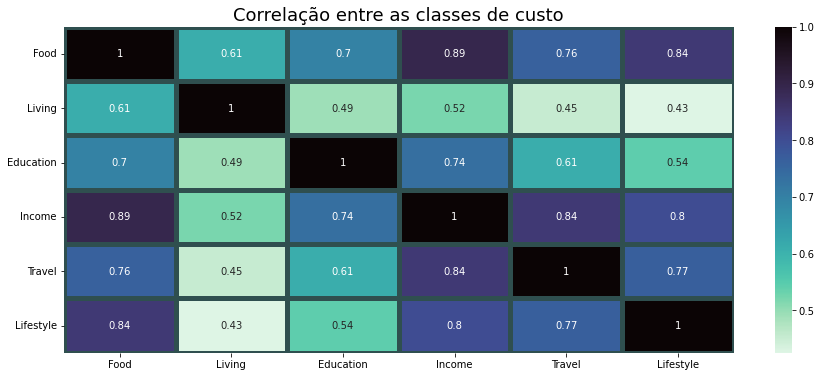

In [25]:
correlation = df_class.iloc[:,1:7].corr()
plt.figure(figsize=(15,6))
sns.heatmap(correlation, cmap='mako_r', annot=True, linewidths=5, linecolor='DarkSlateGray')
plt.title('Correlação entre as classes de custo', size=18)
plt.yticks(rotation='horizontal')
plt.show()

In [39]:
# Cidades e as médias de custos por classe

df[['Country','Food','Travel','Living','Lifestyle','Education','Income']]\
        .groupby('Country').agg('mean')\
        .sort_values(by='Income', ascending=False)\
        .style.background_gradient(cmap='mako_r')

,Food,Travel,Living,Lifestyle,Education,Income
Country,,,,,,
Switzerland,8.000000,28.000000,7932.000000,65.000000,15304.000000,2858.000000
United States,4.692308,18.000000,6261.384615,39.692308,10259.692308,2062.384615
Singapore,5.000000,16.000000,19937.000000,41.000000,9678.000000,1495.000000
Norway,6.000000,23.000000,9544.000000,53.000000,5650.000000,1494.000000
Iceland,6.000000,27.000000,7880.000000,66.000000,3489.000000,1458.000000
Qatar,5.000000,8.000000,5225.000000,48.000000,4728.000000,1416.000000
Denmark,4.000000,20.000000,9126.000000,53.000000,3990.000000,1403.000000
Australia,4.400000,21.600000,4932.200000,38.600000,5919.400000,1400.800000
United Kingdom,4.000000,37.000000,9069.000000,42.000000,11423.000000,1380.000000


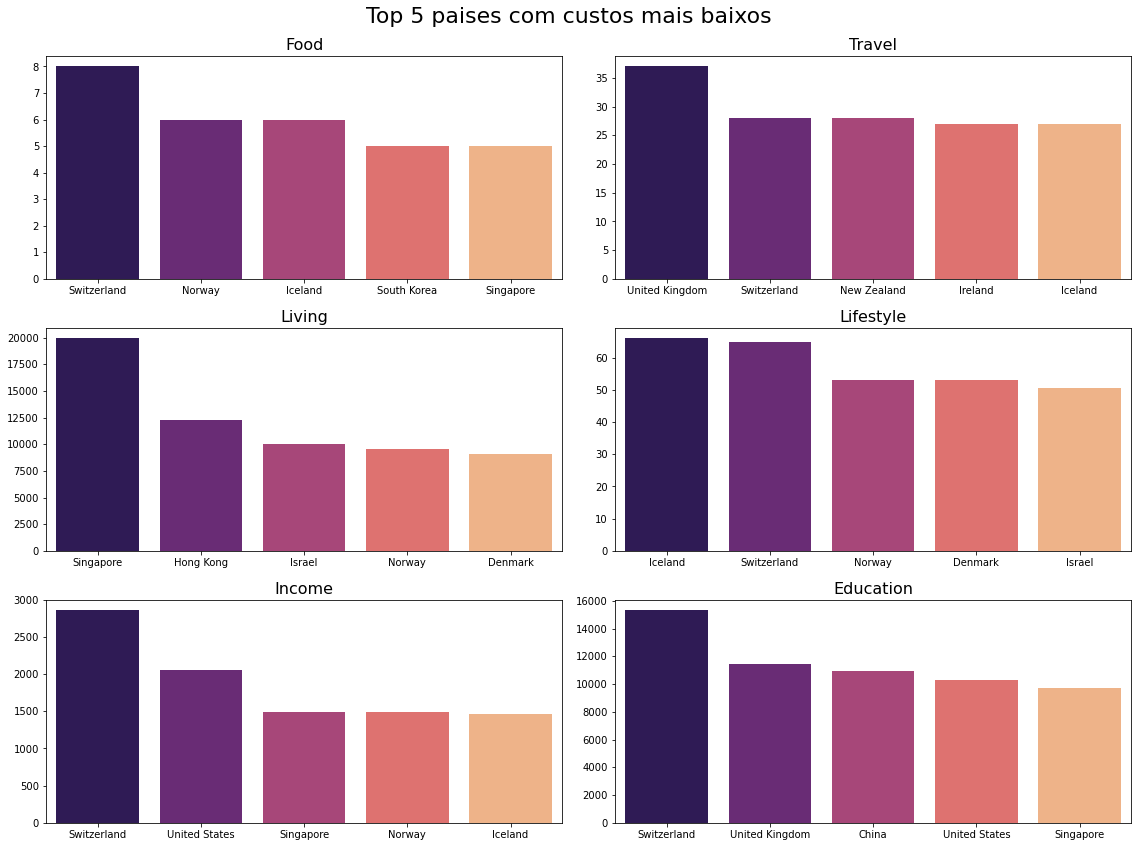

In [56]:
# Gráficos - Top 5 países com maiores custos médios por categoria
colunas = ['Food','Travel','Living','Lifestyle','Income','Education']
plt.figure(figsize=(16,12) )
plt.suptitle('Top 5 paises com custos mais baixos', size=22)

for n, col in enumerate(colunas):
    plt.subplot(3,2,n+1)
    current_df = df[['Country',col]].groupby('Country').agg('mean').sort_values(by=col, ascending=False).reset_index().head(5)
    sns.barplot(x=current_df['Country'].head(5), y=current_df[col], palette='magma')
    plt.ylabel(None)
    plt.xlabel(None)
    plt.title(col, size=16)
plt.tight_layout(pad=1.4)
plt.show()

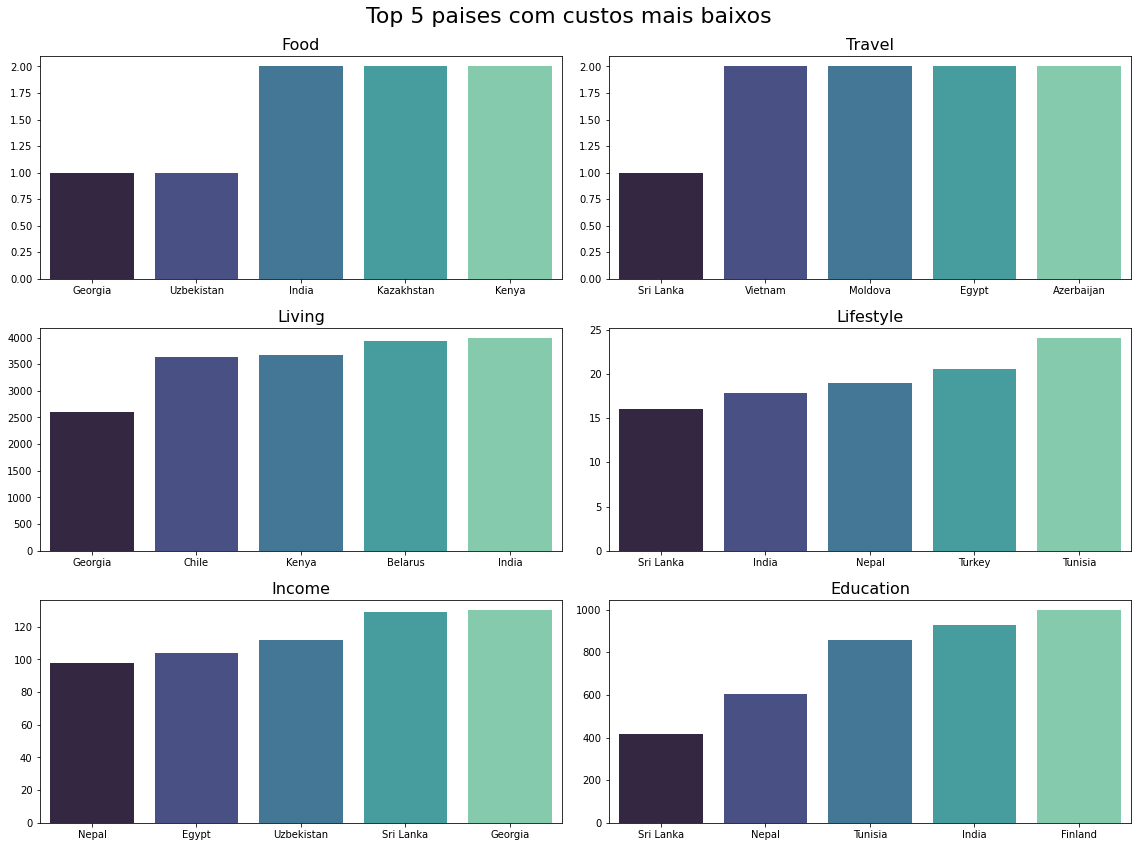

In [54]:
# Gráficos - Top 5 países com menores custos médios por categoria

colunas = ['Food','Travel','Living','Lifestyle','Income','Education']
plt.figure(figsize=(16,12), )
plt.suptitle('Top 5 paises com custos mais baixos', size=22)

for n, col in enumerate(colunas):
    plt.subplot(3,2,n+1)
    current_df = df[['Country',col]].groupby('Country').agg('mean').sort_values(by=col).reset_index().head(5)
    sns.barplot(x=current_df['Country'].head(5), y=current_df[col], palette='mako')
    plt.ylabel(None)
    plt.xlabel(None)
    plt.title(col, size=16)
plt.tight_layout(pad=1.4)
plt.show()

In [16]:
# Classificando range dos valores por classes; maior -> menor
top_range = (df.describe().loc['min',:] / df.describe().loc['max',:]).iloc[-6:].sort_values().to_frame().reset_index()
top_range = top_range.rename(columns={'index':'Class', 0:'min / max'})
top_range['min / max'] = top_range['min / max'].apply(lambda x: round(1/x, 2))
top_range

,Class,min / max
0,Education,43.82
1,Travel,37.00
2,Income,36.31
3,Food,8.00
4,Living,7.64
5,Lifestyle,4.40


In [17]:
# Função para add cores
def color_circles(val):
    if val <= df[item].quantile(.25):
        return 'forestgreen'
    elif val <= df[item].quantile(.50):
        return 'goldenrod'
    elif val <= df[item].quantile(.75):
        return 'Tomato'
    else:
        return 'darkred'

In [57]:
from IPython.display import HTML, display

In [80]:
map.render?

In [79]:
# plot Análise geoespacial 1
map = folium.Map(location=[df['latitude'].mean(),
                           df['longitude'].mean()],
                 tiles="Stamen Terrain",
                 zoom_start=2)

item = top_range.iloc[0][0]

for i in range(0, len(df)):
    Circle(location = [df.iloc[i]['latitude'], df.iloc[i]['longitude']],
           radius=120000,
           tooltip=df.iloc[i]['Location'],
           color=color_circles(df.iloc[i][item])).add_to(map)

print('Preço médio da ',item)
map.g

Preço médio da  Education


In [19]:
# plot Análise geoespacial 2
map = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()],
                 zoom_start=2)

item = top_range.iloc[1][0]


for i in range(0,len(df)):
    Circle(location=[df.iloc[i]['latitude'], df.iloc[i]['longitude']],
           radius=90000,
           tooltip=df.iloc[i]['Location'],
           color=color_circles(df.iloc[i][item])).add_to(map)

print('Preço médio da ',item)
map

Preço médio da  Travel


In [20]:
# plot Análise geoespacial 3
map = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()],
                 tiles='Stamen Watercolor',
                 zoom_start=2)

item = top_range.iloc[2][0]

for i in range(0,len(df)):
    Circle(location=[df.iloc[i]['latitude'], df.iloc[i]['longitude']],
           radius=100000,
           tooltip=df.iloc[i]['Location'],
           color= color_circles(df.iloc[i][item])).add_to(map)

print('Valor médio do ',item)
map

Valor médio do  Income


In [21]:
# plot Análise geoespacial 4
map = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()],
                 tiles='CartoDB positron',
                 zoom_start=2)

item = top_range.iloc[3][0]

for i in range(0,len(df)):
    Circle(location=[df.iloc[i]['latitude'], df.iloc[i]['longitude']],
           radius=100000,
           tooltip=df.iloc[i]['Location'],
           color= color_circles(df.iloc[i][item])).add_to(map)

print('Valor médio do ',item)
map

Valor médio do  Food


In [22]:
# plot Análise geoespacial 5
map = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()],
                 tiles='CartoDB dark_matter',
                 zoom_start=2)

item = top_range.iloc[4][0]

for i in range(0,len(df)):
    Circle(location=[df.iloc[i]['latitude'], df.iloc[i]['longitude']],
           radius=100000,
           tooltip=df.iloc[i]['Location'],
           color= color_circles(df.iloc[i][item])).add_to(map)

print('Valor médio do ',item)
map

Valor médio do  Living


In [23]:
from folium import plugins # adicionando um minimapa

# plot Análise geoespacial 6
map = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()],
                 tiles='Stamen Terrain',
                 zoom_start=3.5)

item = top_range.iloc[5][0]

for i in range(0,len(df)):
    Circle(location=[df.iloc[i]['latitude'], df.iloc[i]['longitude']],
           radius=100000,
           tooltip=df.iloc[i]['Location'],
           color= color_circles(df.iloc[i][item])).add_to(map)
    
minimap = plugins.MiniMap(tile_layer='Stamen Watercolor')    
# map.add_Legend(title='Legenda', labels=['<= 25%', '<= 50%', '<=75%', '> 75%'], colors=['forestgreen','goldenrod','Tomato','Darkred'])
map.add_child(minimap)
print('Valor médio do ',item)
map

Valor médio do  Lifestyle


In [24]:
# Verificando a relação entre as categorias criadas
df_class = df[['Country','Food','Living','Education','Income','Travel','Lifestyle','latitude','longitude']].groupby('Country').agg('mean').reset_index()
df_class.head(3)

,Country,Food,Living,Education,Income,Travel,Lifestyle,latitude,longitude
0,Albania,2.0,4157.0,1225.0,171.0,5.0,29.0,41.328148,19.818444
1,Argentina,2.0,4346.0,1638.0,266.0,3.0,28.0,-34.607568,-58.437089
2,Armenia,2.0,4390.0,1581.0,154.0,3.0,30.0,40.177625,44.512617


In [26]:
# Comparação das classes entre as cidades de determinado país
df['City'] = df['Location'].str.split(', ')
df['City'] = df['City'].apply(lambda x: x[0])

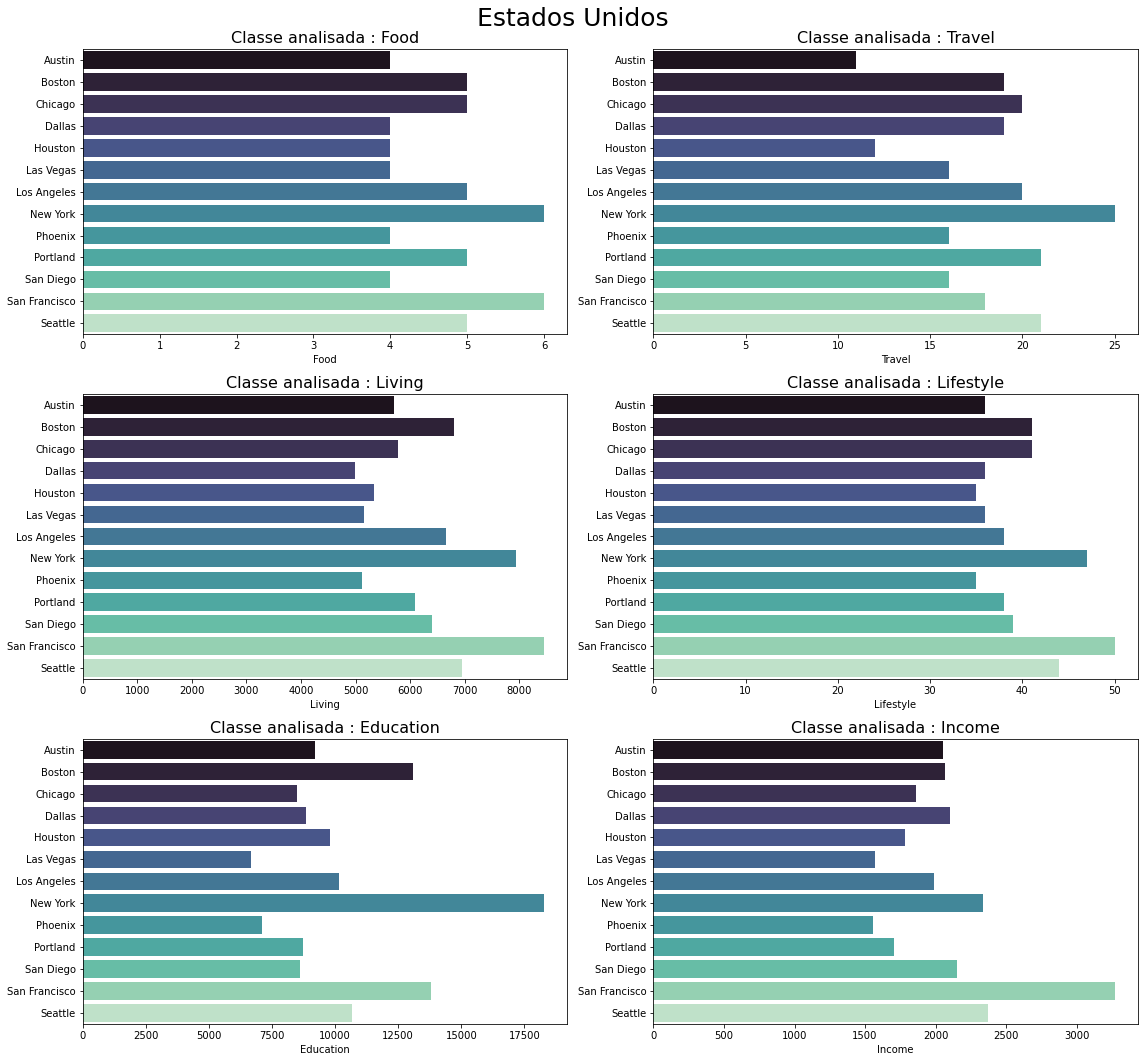

In [68]:
# Analisando os Estados Unidos
df_US = df[df['Country']=='United States']

colunas = ['Food', 'Travel', 'Living', 'Lifestyle', 'Education','Income']
# plot
plt.figure(figsize=(16,15))
plt.suptitle('Estados Unidos', size=25)
for n, col in enumerate(colunas):
    plt.subplot(3,2,n+1)
    sns.barplot(y = df_US['City'], x= df_US[col], palette='mako')
    plt.title(f'Classe analisada : {col}', size=16)
    plt.ylabel(None)
plt.tight_layout()
plt.show()

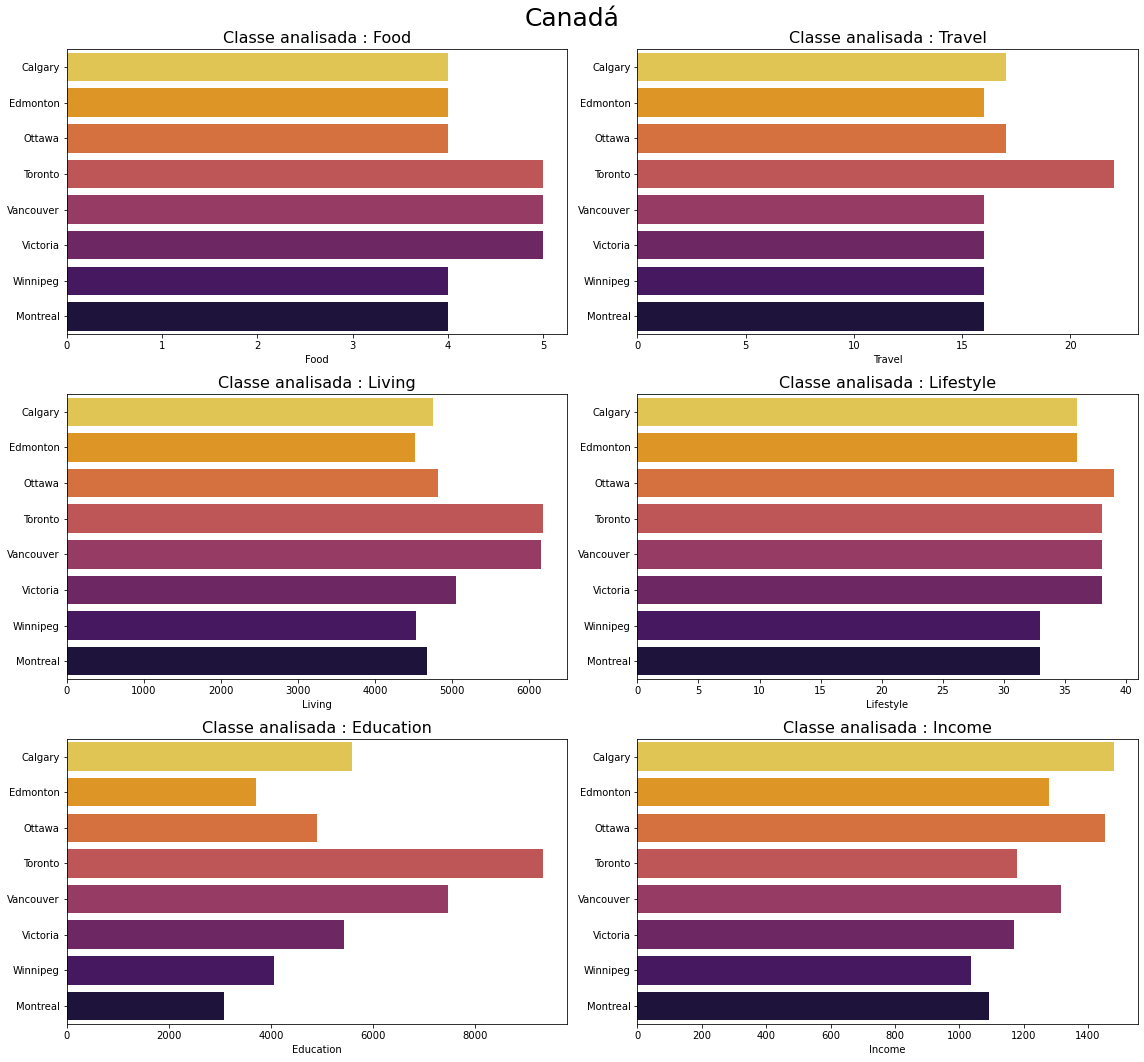

In [67]:
# Analisando os Canada
df_CA = df[df['Country']=='Canada']

colunas = ['Food', 'Travel', 'Living', 'Lifestyle', 'Education','Income']
# plot
plt.figure(figsize=(16,15))
plt.suptitle('Canadá', size=25)
for n, col in enumerate(colunas):
    plt.subplot(3,2,n+1)
    sns.barplot(y = df_CA['City'], x= df_CA[col], palette='inferno_r')
    plt.title(f'Classe analisada : {col}', size=16)
    plt.ylabel(None)
plt.tight_layout()
plt.show()

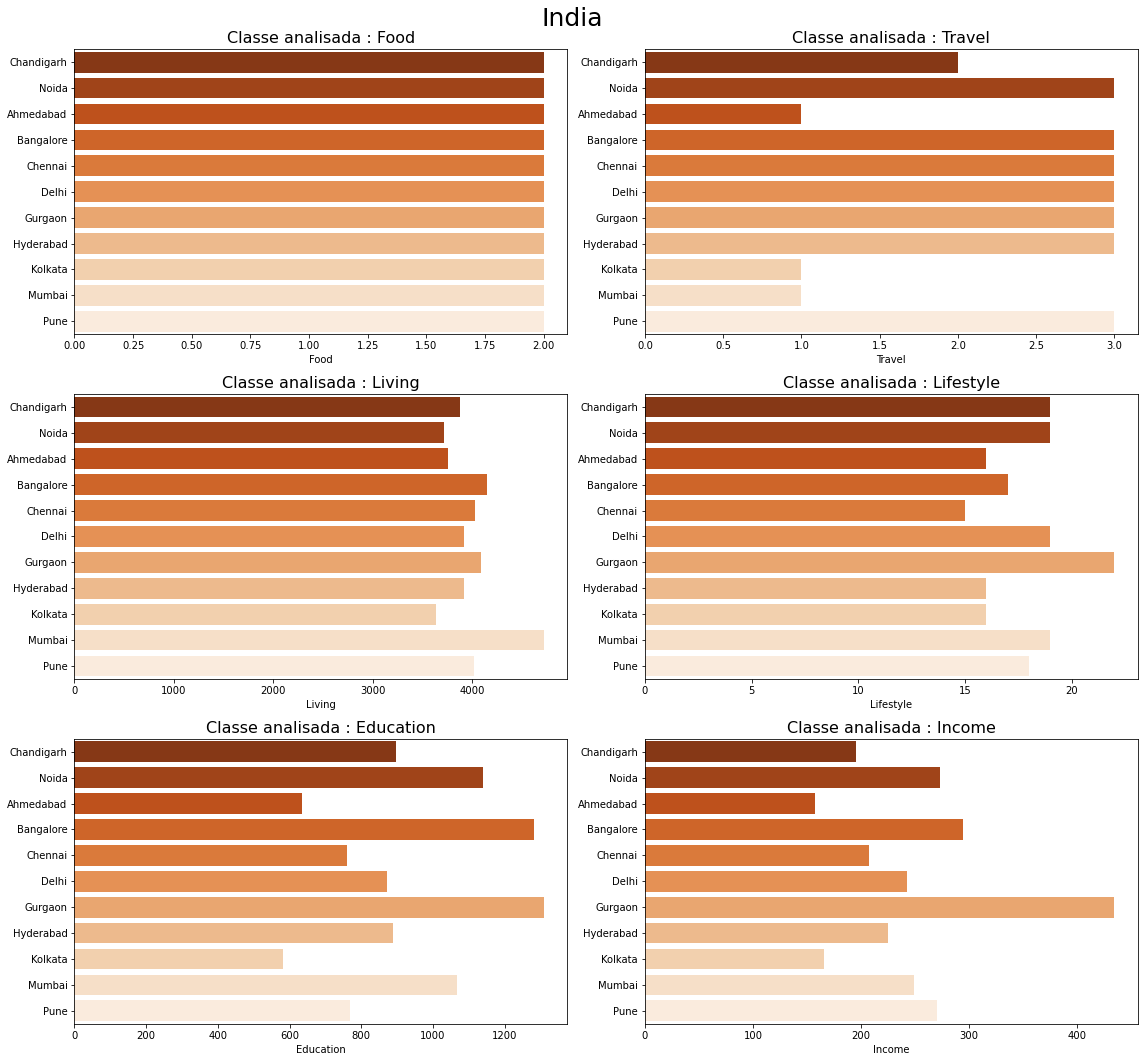

In [66]:
# Analisando os India
df_IN = df[df['Country']=='India']

colunas = ['Food', 'Travel', 'Living', 'Lifestyle', 'Education','Income']
# plot
plt.figure(figsize=(16,15))
plt.suptitle('India', size=25)
for n, col in enumerate(colunas):
    plt.subplot(3,2,n+1)
    sns.barplot(y = df_IN['City'], x= df_IN[col], palette='Oranges_r')
    plt.title(f'Classe analisada : {col}', size=16)
    plt.ylabel(None)
plt.tight_layout()
plt.show()

In [30]:
# Qual a localização que possui a melhor pontuação geral para custo de vida:

df_best_city = df[['Location','Food', 'Travel', 'Living', 'Lifestyle', 'Education','Income','latitude','longitude']].copy()

In [31]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
features_scaled = scaler.fit_transform(df_best_city[['Food', 'Travel', 'Living', 'Lifestyle', 'Education','Income']])
lista=[]
for i in features_scaled:
    numero = round(abs(i).mean(),3)
    lista.append(numero)
df_best_city['Score'] = lista

In [32]:
# Top 10 cidades com maior custo de vida:
df_best_city[['Location','Score']].sort_values(by='Score', ascending=False).head(10)

,Location,Score
144,"Zurich, Switzerland",0.790
78,"New York, NY, United States",0.670
100,"San Francisco, CA, United States",0.660
39,"Singapore, Singapore",0.576
70,"London, United Kingdom",0.559
128,"Reykjavik, Iceland",0.557
102,"Seattle, WA, United States",0.540
50,"Oslo, Norway",0.534
47,"Boston, MA, United States",0.526
71,"Los Angeles, CA, United States",0.487


In [33]:
def color_Score(data, val):
    if val <= data['Score'].quantile(.25):
               return 'forestgreen'
    elif val <= data['Score'].quantile(.50):
                 return 'goldenrod'
    elif val <= data['Score'].quantile(.75):
                 return 'Tomato'
    else:
                 return 'darkred'

In [72]:
top_10_mais = df_best_city[['Location','Score','latitude','longitude']].sort_values(by='Score', ascending=False).head(10)
map = folium.Map(location=[top_10_mais['latitude'].mean(), top_10_mais['longitude'].mean()],
                 tiles='CartoDB positron',
                 zoom_start=2)
for i in range(0,len(top_10_mais)):
    Circle(location=[top_10_mais.iloc[i]['latitude'], top_10_mais.iloc[i]['longitude']],
           radius=150000,
           tooltip=[top_10_mais.iloc[i]['Location'],top_10_mais.iloc[i]['Score']],
           color=color_Score(top_10_mais, top_10_mais.iloc[i]['Score'])).add_to(map)
map

In [35]:
# Top 10 cidades com menor custo de vida:
df_best_city[['Location','Score']].sort_values(by='Score', ascending=True).head(10)

,Location,Score
123,"Kolkata, India",0.043
106,"Ahmedabad, India",0.044
112,"Chennai, India",0.056
63,"Tbilisi, Georgia",0.058
118,"Hyderabad, India",0.060
81,"Chandigarh, India",0.064
130,"Pune, India",0.069
82,"Colombo, Sri Lanka",0.070
114,"Delhi, India",0.071
127,"Mumbai, India",0.072


In [36]:
top_10_menos = df_best_city[['Location','Score','latitude','longitude']].sort_values(by='Score', ascending=True).head(10)

map = folium.Map(location=[top_10_menos['latitude'].mean(), top_10_menos['longitude'].mean()],
                 tiles='CartoDB positron',
                 zoom_start=3)
for i in range(0,len(top_10_menos)):
    Circle(location=[top_10_menos.iloc[i]['latitude'], top_10_menos.iloc[i]['longitude']],
           radius=150000,
           tooltip=[top_10_menos.iloc[i]['Location'],top_10_menos.iloc[i]['Score']],
           color=color_Score(top_10_menos, top_10_menos.iloc[i]['Score'])).add_to(map)

map